In [4]:
%matplotlib inline
from seaborn import apionly as sns

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

plt.style.use(['seaborn-whitegrid', 'seaborn-ticks'])
import matplotlib.ticker as plticker
rcParams['figure.figsize'] = 8, 8
# rcParams['figure.figsize'] = 24, 16

rcParams['axes.facecolor'] = 'FFFFFF'
rcParams['savefig.facecolor'] = 'FFFFFF'
rcParams['figure.facecolor'] = 'FFFFFF'

rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'

rcParams.update({'figure.autolayout': True})

%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np

from tqdm import tqdm

import torch

torch.multiprocessing.set_start_method('spawn', force=True)

In [14]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS, HMC

pyro.set_rng_seed(101)

In [6]:
import uproot

import warnings

warnings.simplefilter('ignore')

In [8]:
!xrdcp root://eoslhcb.cern.ch//eos/lhcb/user/d/dohanlon/baseline_100_ToEPM_test.root tag.root
d = uproot.open("tag.root")['tree']

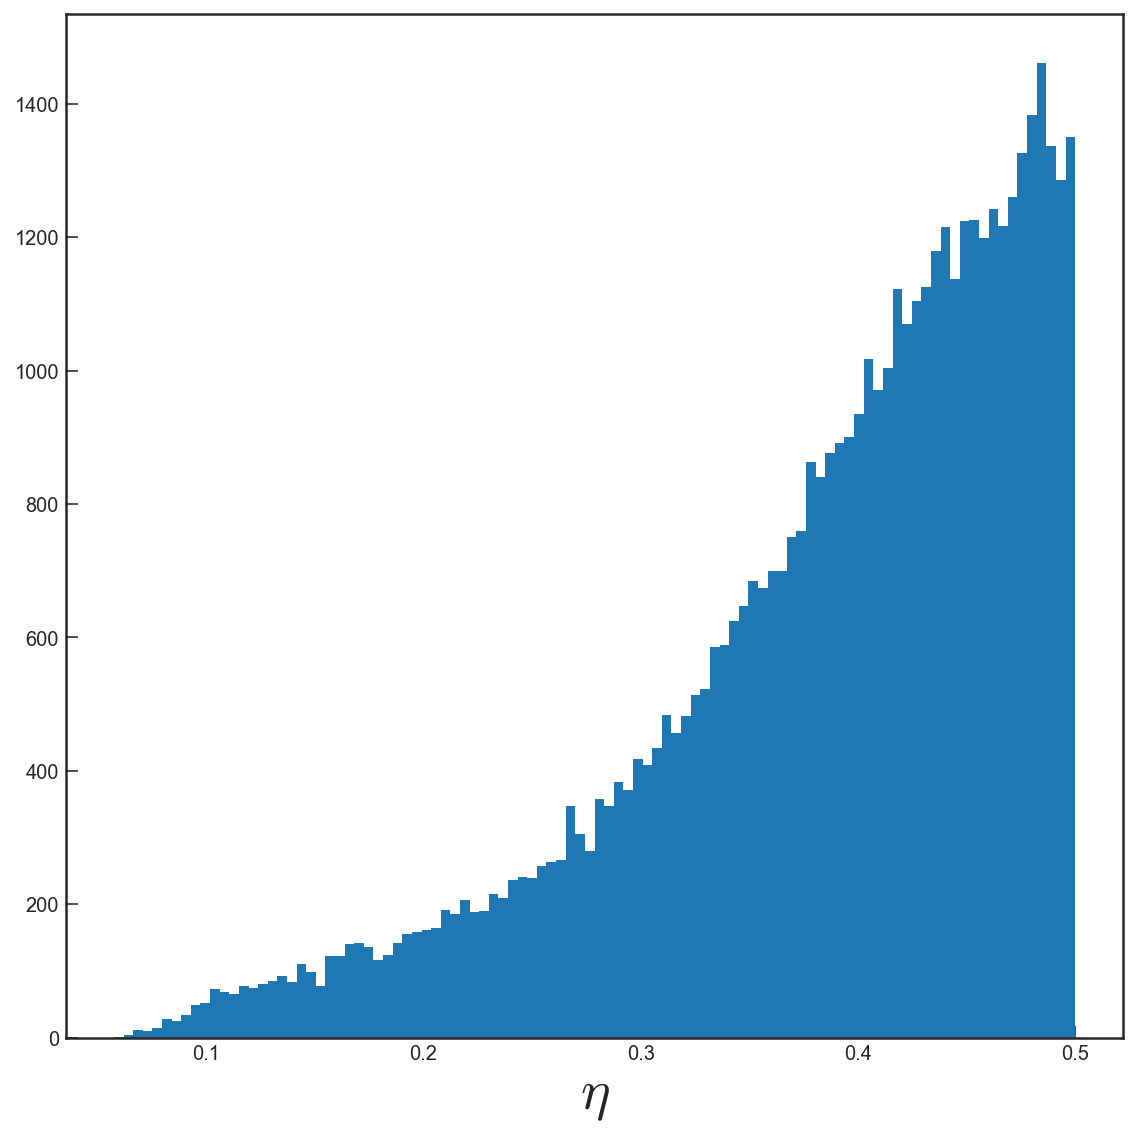

In [9]:
plt.hist(d.array('eta'), bins = 100);
plt.xlabel(r'$\eta$', fontsize = 28);

In [10]:
tagEta = d.array('eta')
tagTrue = d.array('B_ID')
tagTrue[tagTrue == -521] = 0
tagTrue[tagTrue == 521] = 1
tagPred = d.array('tag')
tagPred[tagPred == -1] = 0

tagEtaProb = tagEta
tagEtaProb[tagPred > 0] = (1 - tagEtaProb[tagPred > 0])

In [11]:
def calibrationFunction(a, b, c, eta):
    return a * eta**2 + b * eta + c

In [15]:
def model(eta, tag):
    
    a = pyro.sample("a", dist.Normal(0, 1.0))
    b = pyro.sample("b", dist.Normal(1, 1.0))
    c = pyro.sample("c", dist.Normal(0, 1.0))
    
    omega = calibrationFunction(a, b, c, eta)
    
    with pyro.plate("eta", len(eta)):
        prob = pyro.sample('prob', dist.Bernoulli(omega), obs = tag)

In [26]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000, warmup_steps=1000)

In [27]:
mcmc.run(torch.tensor(tagEtaProb, dtype = torch.float32), torch.tensor(tagTrue, dtype = torch.float32))

Sample: 100%|██████████| 11000/11000 [15:58, 11.48it/s, step size=5.70e-02, acc. prob=0.936]


In [28]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

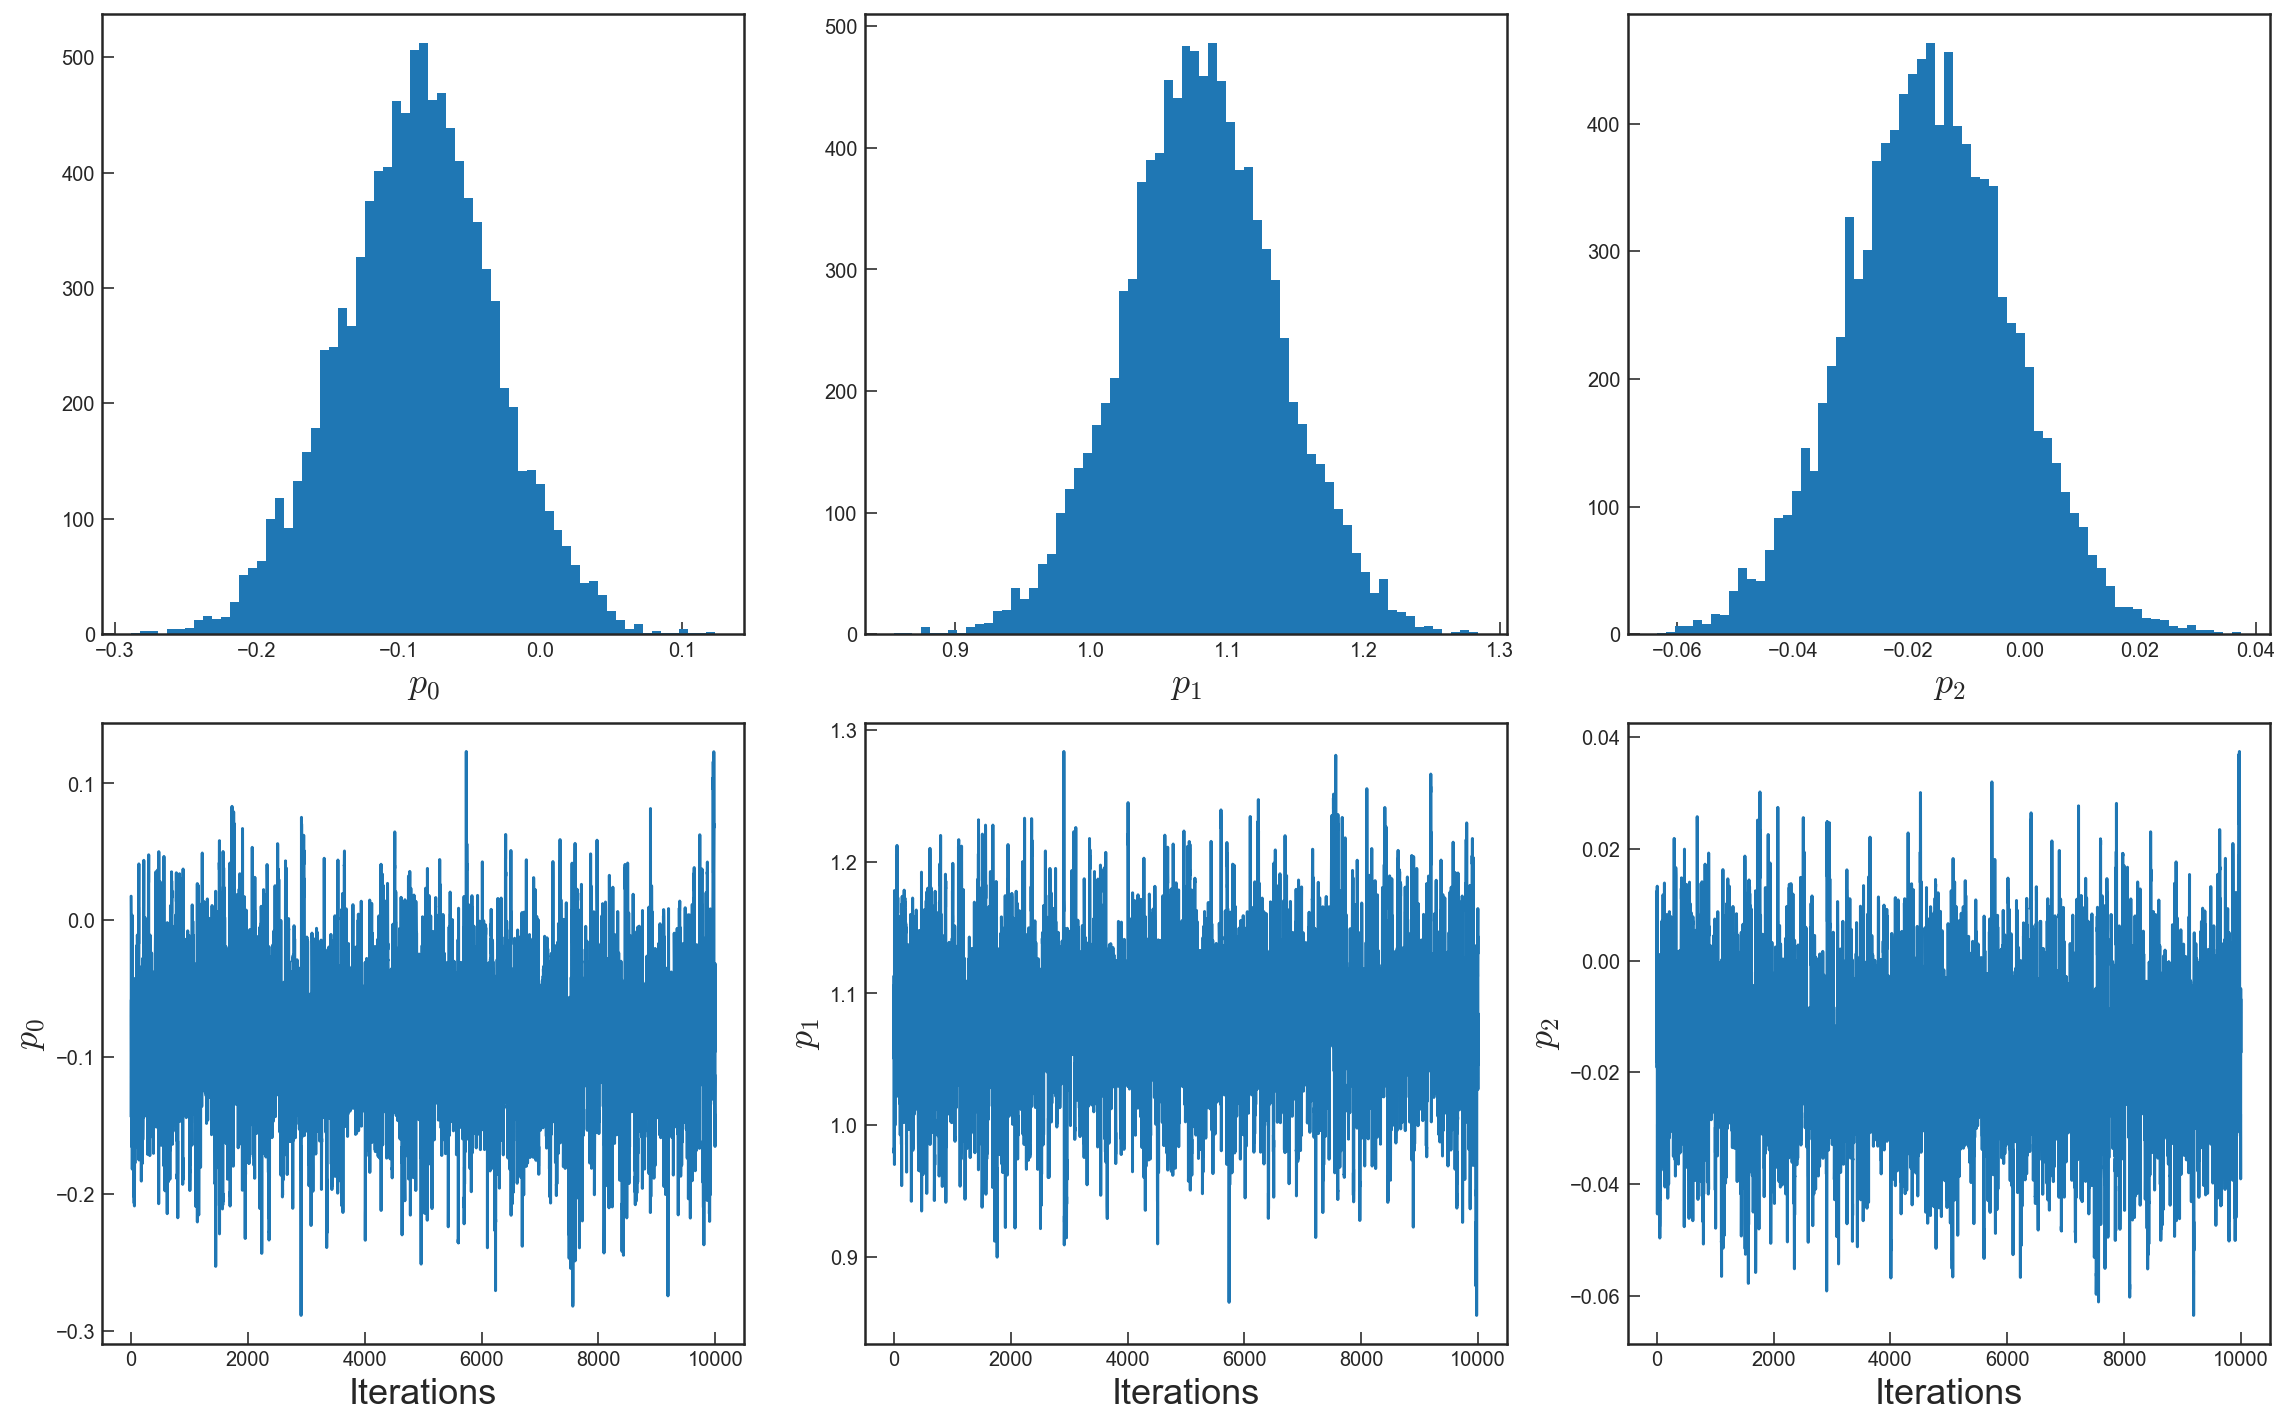

In [29]:
fig, ax = plt.subplots(2, 3, figsize = (16, 10))

ax[1][0].plot(hmc_samples['a']);
ax[1][0].set_xlabel('Iterations', fontsize = 18);
ax[1][0].set_ylabel(r'$p_0$', fontsize = 18);
ax[1][1].plot(hmc_samples['b']);
ax[1][1].set_xlabel('Iterations', fontsize = 18);
ax[1][1].set_ylabel(r'$p_1$', fontsize = 18);
ax[1][2].plot(hmc_samples['c']);
ax[1][2].set_xlabel('Iterations', fontsize = 18);
ax[1][2].set_ylabel(r'$p_2$', fontsize = 18);

ax[0][0].hist(hmc_samples['a'], bins = 65);
ax[0][0].set_xlabel(r'$p_0$', fontsize = 18);
ax[0][1].hist(hmc_samples['b'], bins = 65);
ax[0][1].set_xlabel(r'$p_1$', fontsize = 18);
ax[0][2].hist(hmc_samples['c'], bins = 65);
ax[0][2].set_xlabel(r'$p_2$', fontsize = 18);

In [30]:
from scipy.stats import binned_statistic

In [31]:
bins = np.linspace(0, 0.5, 75)

aVal = np.mean(hmc_samples['a'])
bVal = np.mean(hmc_samples['b'])
cVal = np.mean(hmc_samples['c'])

statNominal, _, _ = binned_statistic(tagEta, values = (tagPred != tagTrue).astype(np.int32), statistic = lambda x : np.sum(x) / float(len(x)), bins = bins)
statBS = []

# Let's do some bootstrapping
for i in tqdm(range(1000)):
    idxs = np.random.choice(range(len(tagEta)), size = len(tagEta), replace = True)
    stat, _, _ = binned_statistic(tagEta[idxs], values = (tagPred[idxs] != tagTrue[idxs]).astype(np.int32), statistic = lambda x : np.sum(x) / float(len(x)), bins = bins)
    statBS.append(stat)

100%|██████████| 1000/1000 [00:18<00:00, 55.23it/s]


In [32]:
statBSErrs = np.nanstd(statBS, axis = 0)

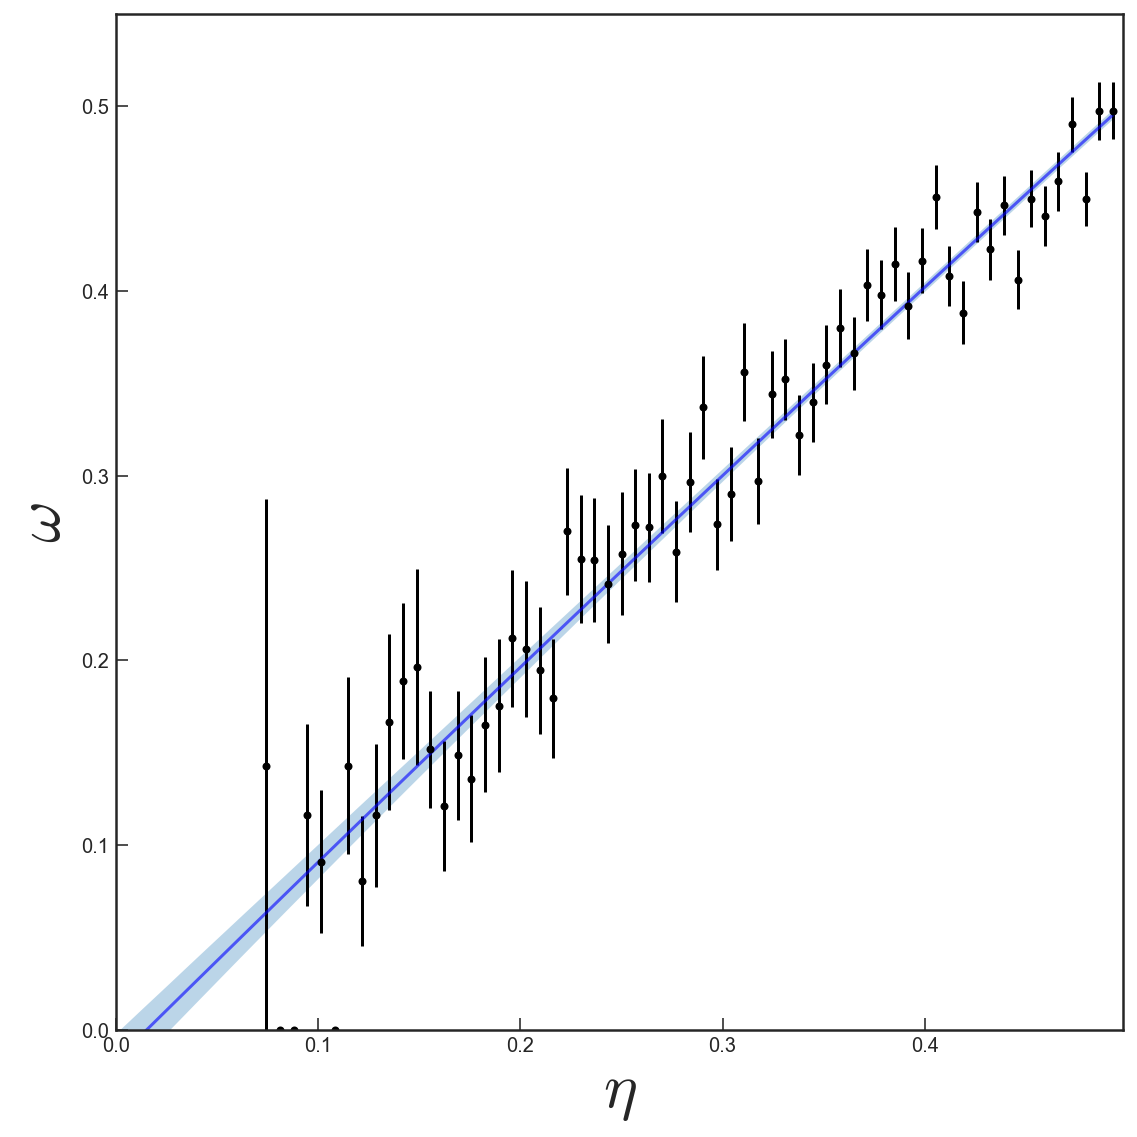

In [33]:
ySamples = calibrationFunction(hmc_samples['a'].reshape(1, -1),
                            hmc_samples['b'].reshape(1, -1),
                            hmc_samples['c'].reshape(1, -1),
                            bins[:-1].reshape(-1, 1))

yErrLow = np.percentile(ySamples, 16, axis = 1)
yErrHigh = np.percentile(ySamples, 84, axis = 1)

y = calibrationFunction(aVal, bVal, cVal, bins[:-1])

plt.errorbar(bins[:-1], statNominal, yerr = statBSErrs, fmt = '.', color = 'k')
plt.plot(bins[:-1], y, color = 'blue', alpha = 0.6)
plt.fill_between(bins[:-1], yErrLow, yErrHigh, alpha = 0.3)

plt.xlim(0, bins[-2] + 0.005)
plt.ylim(0, 0.55)
plt.ylabel(r'$\omega$', fontsize = 32);
plt.xlabel(r'$\eta$', fontsize = 32);

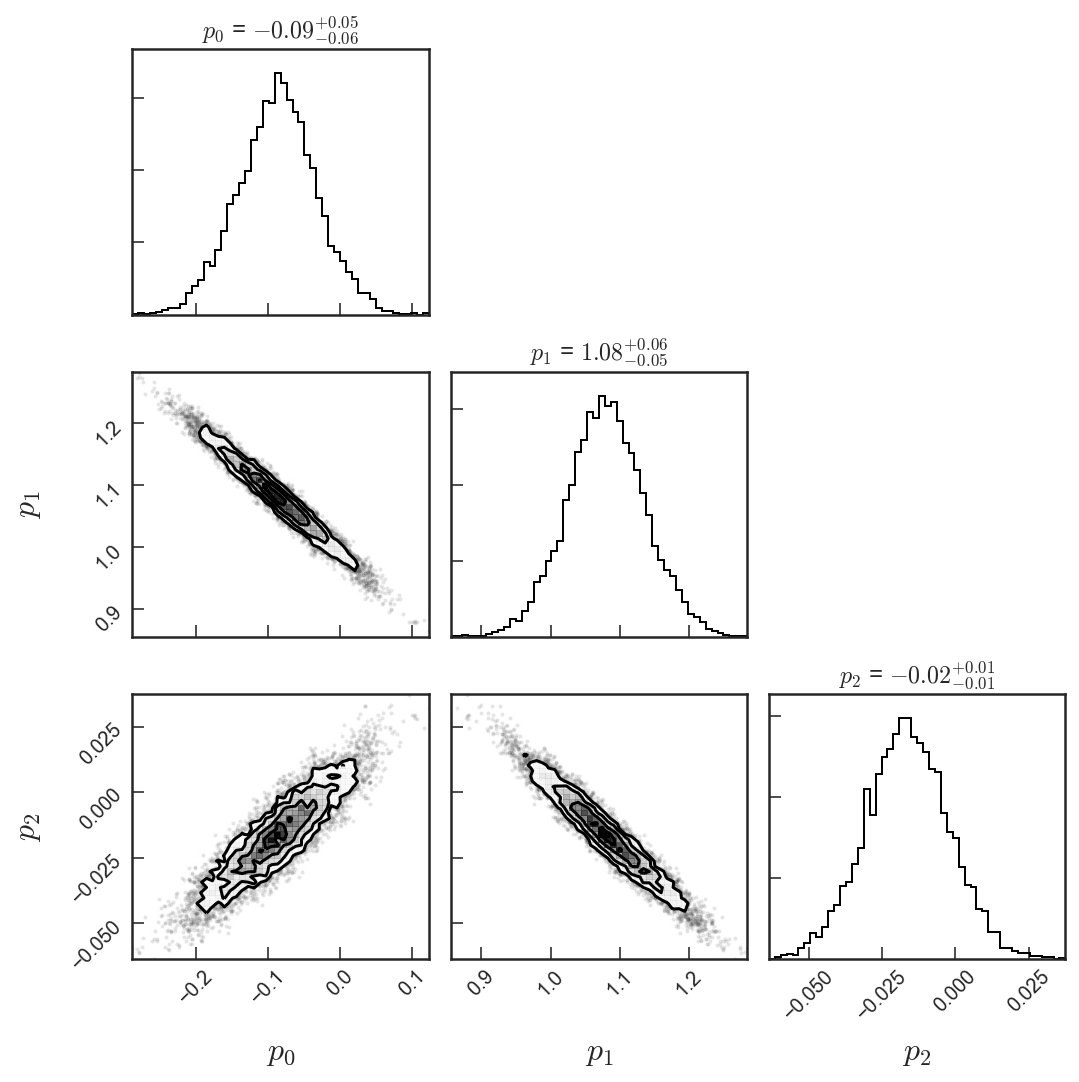

In [34]:
from corner import corner

data = np.vstack((hmc_samples['a'], hmc_samples['b'], hmc_samples['c'])).T

corner(data, labels = [r'$p_0$', r'$p_1$', r'$p_2$'], show_titles = True, label_kwargs=dict(fontsize=16), bins = 50);